# 01_Basic-SVM

Following example: https://www.kaggle.com/code/nishan192/mnist-digit-recognition-using-svm

**Objective** Use an SVM to classify images of handwritten digits 0-9.

**Data** The data are the raw pixels, and the label is the digit 0-9. Each image is 28 x 28 --> 784 features

**Install**
Python3, pandas, numpy, matplotlib, seaborn
```
pip install torch
pip install scikit-learn
pip install torchvision
pip install numpy==1.24.1
pip install tqdm
```

**Run**
```
conda activate klab_rotation_env
```

In [10]:
import numpy as np
import pandas as pd
import os
import tqdm

## Load Data

Taken from Pytorch basics tutorial: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve, KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from torch.utils.data import Dataset
from torchvision import datasets # get Fashion-MNIST
from torchvision.transforms import ToTensor

In [13]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    # transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False, # get testing data
    download=False,
    # transform=ToTensor()
)

### Data Visualization

In [14]:
def dataset_to_df(dataset):
    labels = []
    pixels = []
    for pix, label in tqdm.tqdm(dataset):
        labels.append(label)
        pixels.append(np.array(pix).flatten())
    df = pd.DataFrame(np.array(pixels), index=labels)
    df.index.name = 'label'
    pixel_cols = df.columns.tolist()
    df = df.reset_index()
    return df, pixel_cols

In [15]:
train_df, pixel_cols = dataset_to_df(training_data)
test_df, pixel_cols = dataset_to_df(test_data)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 28940.29it/s]


In [16]:
display(train_df.head())
display(test_df.head())

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
print(train_df.isna().any().any())
print(test_df.isna().any().any())

False
False


In [18]:
display(train_df.describe())
display(test_df.describe())

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
count,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,4.443400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179300,0.163600,0.052600,0.0006,0.0,0.0,0.0,0.0,0.0,0.0
std,2.895865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.674149,5.736072,2.420004,0.0600,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,156.000000,6.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 783
dtypes: int64(1), uint8(784)
memory usage: 45.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 783
dtypes: int64(1), uint8(784)
memory usage: 7.6 MB
None


In [20]:
print(train_df.columns)
print(test_df.columns)

Index(['label',       0,       1,       2,       3,       4,       5,       6,
             7,       8,
       ...
           774,     775,     776,     777,     778,     779,     780,     781,
           782,     783],
      dtype='object', length=785)
Index(['label',       0,       1,       2,       3,       4,       5,       6,
             7,       8,
       ...
           774,     775,     776,     777,     778,     779,     780,     781,
           782,     783],
      dtype='object', length=785)


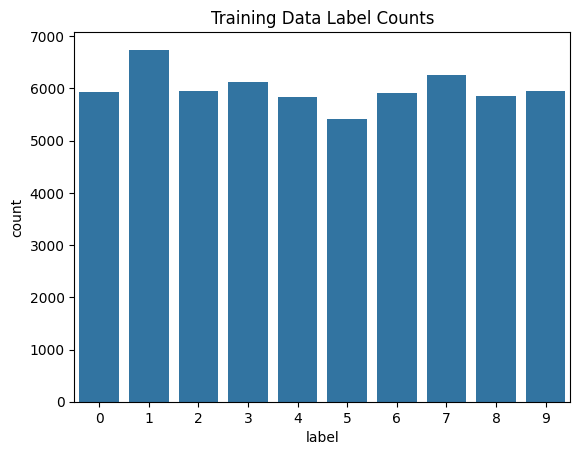

In [25]:
sns.barplot(train_df["label"].value_counts())
plt.title("Training Data Label Counts")
plt.show()

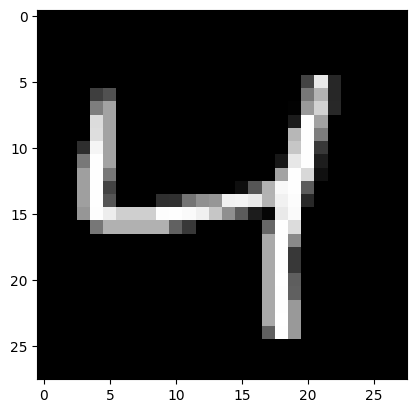

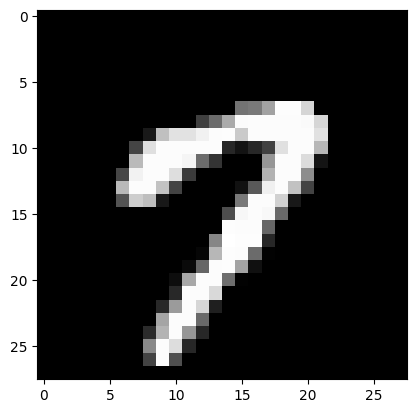

In [31]:
# Plot a number
for num in [4, 7]:
    plt.imshow(train_df.query(f"label == {num}").iloc[0][pixel_cols].values.reshape(28, 28), cmap='gray')
    plt.show()

## Data Preparation

- Test if rescaling is needed
- Separate labels in training data

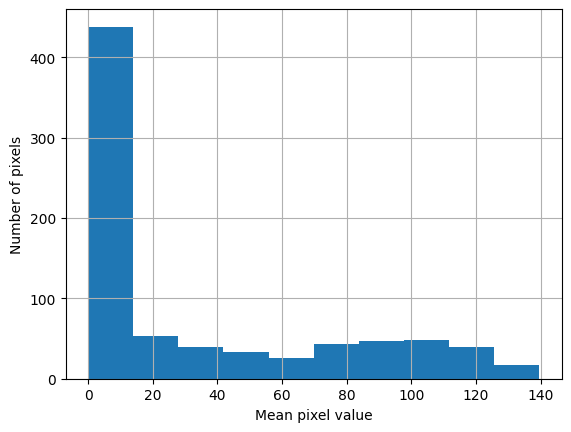

In [33]:
train_df[pixel_cols].mean().hist()
plt.xlabel('Mean pixel value')
plt.ylabel('Number of pixels')
plt.show()

In [37]:
# separate labels
train_y = train_df['label'].copy()
train_X = train_df[pixel_cols].copy()

# Normalize
train_X /= 255.0 # max pixel value

norm_test_df = test_df[pixel_cols].copy()
norm_test_df /= 255.0

print(train_X.shape)
print(norm_test_df.shape)

(60000, 784)
(10000, 784)


In [49]:
# Scale features
from sklearn.preprocessing import scale
# Standardize dataset along an axis. Center to the mean and component wise scale to unit variance
train_X_scaled = scale(train_X)

In [48]:
train_X_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
# train test split
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(
    train_X_scaled,
    train_y,
    test_size=0.3,
    train_size=0.2,
    random_state=10
)

## Model building

[Support Vector Classification (SVC)](https://scikit-learn.org/dev/modules/svm.html#svm-kernels):
- Supervised learning method for classification, regression, and outlier detection
- Can customize kernel
- require 5-fold cross validation to estimate classification probabilities (expensive)
- Not scsale invariant, so **must scale your data**.

### Mathematical formulation

SVMs constructs hyperplane(s) to maximally separate a space or margine between data points. It uses the training data points closest to the hyperplane as the **support vectors**.

Given training data $x_1, \dots, x_n$ where $x_i = \mathbb{R}^p$, and a vector $y \in \{1, -1\}^n$ (two classes), we want to find $w\in\mathbb{R}^p$ and $b\in \mathbb{R}$ such that $\text{sign}(w^T\phi(x_i) + b) = y_i$ for most $i$.

The idea is to (1) maximize the size of the margin, which means minimizing $||w||^2 = w^T w$ (squared Euclidean distance), while (2) incurring a penalty for misclassifications or samples fall within the margin boundary.

We minimize $||w||^2$ because the margin is $\frac{2}{||w||^2}$. This is given by the definition of $w$, the normal vector that defines the decision plane, and the equations for the boundaries:
$$w^Tx - b = 1$$
$$w^Tx - b = -1$$

The primary boundary is similar:
$$w^Tx - b = 0$$

### Linear model

https://scikit-learn.org/dev/modules/svm.html#kernel-functions

Notated as a dot product or inner product $\langle x - x' \rangle$

In [60]:
model_linear = SVC(kernel='linear')
model_linear.fit(split_X_train, split_y_train)

y_pred = model_linear.predict(split_X_test)

In [63]:
from sklearn import metrics

In [65]:
print(f"Accuracy: {metrics.accuracy_score(y_true=split_y_test, y_pred= y_pred)}")
print(metrics.confusion_matrix(y_true=split_y_test, y_pred= y_pred))

Accuracy: 0.9103333333333333
[[1719    0   10    5    3   16   12    1    6    0]
 [   1 1951   11    5    5    4    0    3   11    1]
 [  11   26 1676   30   23    5   23   19   17    1]
 [  10    4   47 1627    4   66    5   19   42   10]
 [   4    8   21    1 1658    5   14    6    5   50]
 [  21    9   19   87   12 1423   30    1   39   11]
 [  20    7   23    1   14   20 1666    2    4    0]
 [   7   13   19   16   31    4    2 1774    5   93]
 [  25   44   49   54   12   58   18   11 1436   17]
 [   4   11   19   23   90    9    1   69   20 1456]]


**Confusion matrix**: shows the number of correct and incorrectly classified data. Each row and column corresponds to one of the possible classes. the $i^{\text{th}}$ row and $j^{\text{th}}$ column entry is the number of samples with the true label being the $i^{\text{th}}$ class and the predicted label being the $j^{\text{th}}$ class.

### Non-linear model

https://scikit-learn.org/dev/modules/svm.html#kernel-functions

Here, we pick random hyperparameters for the Radial Basis Function (RBF) kernel. Here, $\gamma > 0$, and influences a single training example has. If large, the closer other examples must be to be affected.

$$\text{exp}(-\gamma||x - x'||^2)$$

An additional parameter is $C$, where lower values makes the decision more smooth, which a higher value aims to classify everything correctly. 

In [66]:
non_linear_model = SVC(kernel='rbf')
non_linear_model.fit(split_X_train, split_y_train)
non_lin_y_pred = non_linear_model.predict(split_X_test)

In [67]:
print(f"Accuracy: {metrics.accuracy_score(y_true=split_y_test, y_pred= non_lin_y_pred)}")
print(metrics.confusion_matrix(y_true=split_y_test, y_pred= non_lin_y_pred))

Accuracy: 0.943
[[1722    0   15    4    1    6   13    2    8    1]
 [   1 1947   21    7    5    0    1    2    7    1]
 [   5    6 1747   11   12    3   14   16   14    3]
 [   2    3   52 1685    1   37    2   21   26    5]
 [   1    5   31    1 1664    5    9    7    4   45]
 [   3    5   28   33    3 1526   27    5   15    7]
 [   8    4   21    0    4   14 1698    1    7    0]
 [   3   11   52    7   14    0    0 1828    2   47]
 [  10   22   32   18    9   26   11    5 1585    6]
 [   3    5   25   17   23    4    0   38   15 1572]]


### Non-linear model hyperparameter tuning

Find optimal $C$ and $\gamma$ using 5-fold cross validation

In [131]:
# Kfold provides train/test indices to split data in train/test sets. 
# Each fold is used once a validation, while the k-1 remaining folds are the training set
folds = KFold(n_splits=5, shuffle=True, random_state=10)
folds

KFold(n_splits=5, random_state=10, shuffle=True)

In [132]:
# To test
hyper_params = [{
    'gamma': [1e-2, 1e-3, 1e-4],
    'C': [5, 10]
}]

In [133]:
rbf_model = SVC(kernel='rbf')

In [134]:
rbf_model_cv = GridSearchCV(
    estimator=rbf_model,
    param_grid=hyper_params,
    scoring='accuracy',
    cv=folds,
    verbose=1,
    return_train_score=True,
    # n_jobs=4,
)

In [135]:
split_X_train.shape


(12000, 784)

In [136]:
rbf_model_cv.fit(split_X_train[:1000, :], split_y_train[:1000]) # taking too long to run

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [5, 10], 'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [137]:
cv_results_df = pd.DataFrame(rbf_model_cv.cv_results_)
cv_results_df['param_C'] = cv_results_df['param_C'].astype(str)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.209905,0.009907,0.063561,0.007044,5,0.0100,"{'C': 5, 'gamma': 0.01}",0.555,0.595,0.600,...,0.599,0.025962,5,1.0000,1.000,1.0000,1.00000,1.0000,1.00000,0.000000
1,0.116747,0.011289,0.045248,0.004121,5,0.0010,"{'C': 5, 'gamma': 0.001}",0.895,0.860,0.840,...,0.857,0.034871,2,1.0000,1.000,1.0000,1.00000,1.0000,1.00000,0.000000
2,0.093863,0.007115,0.042855,0.002857,5,0.0001,"{'C': 5, 'gamma': 0.0001}",0.865,0.850,0.835,...,0.848,0.016000,4,0.9325,0.925,0.9375,0.93750,0.9325,0.93300,0.004583
3,0.190352,0.009539,0.051961,0.003957,10,0.0100,"{'C': 10, 'gamma': 0.01}",0.555,0.595,0.600,...,0.599,0.025962,5,1.0000,1.000,1.0000,1.00000,1.0000,1.00000,0.000000
4,0.110743,0.003340,0.041468,0.002499,10,0.0010,"{'C': 10, 'gamma': 0.001}",0.895,0.865,0.835,...,0.856,0.034699,3,1.0000,1.000,1.0000,1.00000,1.0000,1.00000,0.000000
5,0.089244,0.007408,0.044238,0.004843,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.880,0.835,0.850,...,0.862,0.022045,1,0.9650,0.970,0.9650,0.95625,0.9625,0.96375,0.004472


In [138]:
accuracy_scores_df = cv_results_df.set_index(['param_gamma', 'param_C'])[
['mean_test_score', 'mean_train_score']
].stack().reset_index().rename(columns={'level_2': 'mean_score_source', 0: 'accuracy_score'})
accuracy_scores_df

,param_gamma,param_C,mean_score_source,accuracy_score
0,0.0100,5,mean_test_score,0.59900
1,0.0100,5,mean_train_score,1.00000
2,0.0010,5,mean_test_score,0.85700
3,0.0010,5,mean_train_score,1.00000
4,0.0001,5,mean_test_score,0.84800
5,0.0001,5,mean_train_score,0.93300
6,0.0100,10,mean_test_score,0.59900
7,0.0100,10,mean_train_score,1.00000
8,0.0010,10,mean_test_score,0.85600
9,0.0010,10,mean_train_score,1.00000


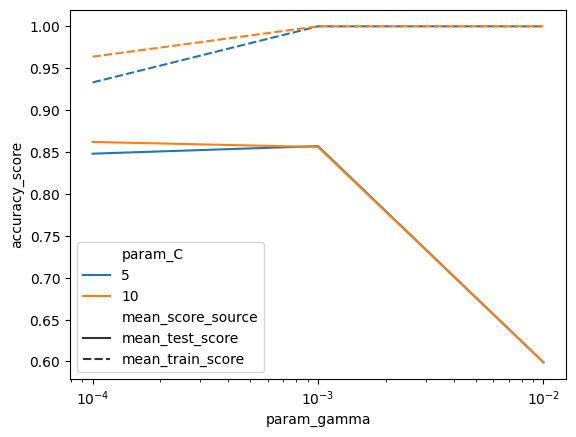

In [139]:
sns.lineplot(
    accuracy_scores_df,
    x='param_gamma',
    y='accuracy_score',
    hue='param_C',
    style='mean_score_source'
)
plt.xscale('log')
plt.show()

In [142]:
best_score = rbf_model_cv.best_score_
best_hyperparams = rbf_model_cv.best_params_
print(best_score, best_hyperparams)

0.8620000000000001 {'C': 10, 'gamma': 0.0001}


## Build and evaluate final model

In [144]:
opt_model = SVC(kernel="rbf", **best_hyperparams)
opt_model.fit(split_X_train, split_y_train)
opt_y_pred = opt_model.predict(split_X_test)

In [145]:
print(f"Accuracy: {metrics.accuracy_score(y_true=split_y_test, y_pred= opt_y_pred)}")
print(metrics.confusion_matrix(y_true=split_y_test, y_pred= opt_y_pred))

Accuracy: 0.9341111111111111
[[1718    0    7    7    2   12   10    2   12    2]
 [   1 1940   21    9    4    3    0    2    9    3]
 [  11   14 1706   11   22    6   19   15   24    3]
 [   4    5   47 1652    3   64    4   17   32    6]
 [   3    5   13    1 1685    5   10    2    3   45]
 [   9   10   12   42   13 1499   30    1   23   13]
 [   8    7   12    0    9   17 1697    0    7    0]
 [   4   18   20    6   25    2    1 1821    6   61]
 [  10   40   27   26   11   37   13    6 1546    8]
 [   7    9   14   21   46    8    0   31   16 1550]]
